# Diurnal variations of wind 


This notebook look into the wind velocity parameters from the model outputs 

In [1]:
import xarray as xr
from pathlib import Path
import pandas as pd
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import easygems.healpix as egh
import numpy as np
from functools import partial
from matplotlib import cm

In [32]:
import os
import subprocess
import glob
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
from dask.distributed import Client

In [4]:
import sys
sys.path.append("/home/130/ae7501/hk25-AusNode-coastal/sea_breeze_code/")
import sea_breeze_funcs

In [5]:
client=Client()
client

<Client: 'tcp://127.0.0.1:34367' processes=7 threads=28, memory=125.19 GiB>

In [6]:
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z8.zarr" #PT1H is hourly data
ds = xr.open_zarr(data_2d_z2)
ds = ds.pipe(partial(egh.attach_coords))
ds

<xarray.Dataset> Size: 792GB
Dimensions:  (time: 10489, cell: 786432)
Coordinates:
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
    crs      int64 8B 0
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    lat      (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables: (12/24)
    clivi    (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    clt      (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    clwvi    (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    hflsd    (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    hfssd    (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    huss     (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    rsutcs   (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    tas      (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    ts       (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    uas      (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
    vas      (time, cell) float32 33GB dask.array<chunksize=(16, 65536), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [7]:
files = glob.glob("/g/data/rt52/era5/single-levels/reanalysis/10u/2020/10u_era5_oper_sfc_20200101-20200131.nc")
print(files)

['/g/data/rt52/era5/single-levels/reanalysis/10u/2020/10u_era5_oper_sfc_20200101-20200131.nc']


In [8]:
file_list1 = sorted(
    glob.glob("/g/data/rt52/era5/single-levels/reanalysis/10u/2020/*.nc") +
    glob.glob("/g/data/rt52/era5/single-levels/reanalysis/10u/2021/*.nc")
)
file_list2 = sorted(
    glob.glob("/g/data/rt52/era5/single-levels/reanalysis/10v/2020/*.nc") +
    glob.glob("/g/data/rt52/era5/single-levels/reanalysis/10v/2021/*.nc")
)
era5_u10 = xr.open_mfdataset(file_list1, combine='by_coords')
era5_v10 = xr.open_mfdataset(file_list2, combine='by_coords')

In [10]:
# slect the wind data u and v components for era5
ue1=era5_u10.u10.sel(time=slice("2020-04-01", "2020-09-30"))
ue2=era5_u10.u10.sel(time=slice("2020-10-01", "2021-04-01"))
ve1=era5_v10.v10.sel(time=slice("2020-04-01", "2020-09-30"))
ve2=era5_v10.v10.sel(time=slice("2020-10-01", "2021-04-01"))
velocity1 = (ue1**2 + ve1**2)**0.5
velocity2 = (ue2**2 + ve2**2)**0.5

In [8]:
# slect the wind data u and v components
u1=ds.uas.sel(time=slice("2020-04-01", "2020-09-30"))
u2=ds.uas.sel(time=slice("2020-10-01", "2021-04-01"))
v1=ds.vas.sel(time=slice("2020-04-01", "2020-09-30"))
v2=ds.vas.sel(time=slice("2020-10-01", "2021-04-01"))
velocity1 = (u1**2 + v1**2)**0.5
velocity2 = (u2**2 + v2**2)**0.5

### average functions

In [11]:
def monthly_hourly_average(data):
    """
    Compute the time average for each hour of the day across all days, separately for each month.
    """
    # Group by month, then by hour, and compute the mean over time within each group
    monthly_hourly_avg = data.groupby('time.month').apply(lambda x: x.groupby('time.hour').mean('time'))
    
    return monthly_hourly_avg


In [13]:
def hourly_average(data):
    """
    Compute the time average for each hour of the day across all days for whole time period
    """
    # Group by month, then by hour, and compute the mean over time within each group
    hourly_avg = data.groupby('time.hour').mean('time')
    
    return hourly_avg


In [14]:
# get the average velocities and save to folder
data1 = velocity1
hourly_avg_velocity1 = hourly_average(data1)
hourly_avg_velocity1.to_netcdf("/g/data/nf33/hk25_AusNode_coastal/ae7501/era_hourly_avg1.nc")

data2 = velocity2
hourly_avg_velocity2 = hourly_average(data2)
hourly_avg_velocity2.to_netcdf("/g/data/nf33/hk25_AusNode_coastal/ae7501/era_hourly_avg2.nc")


INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True


In [15]:
hourly_avg_velocity1 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501/hourly_avg_velocity1.nc').__xarray_dataarray_variable__
hourly_avg_velocity2 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501/hourly_avg_velocity2.nc').__xarray_dataarray_variable__

### healpix

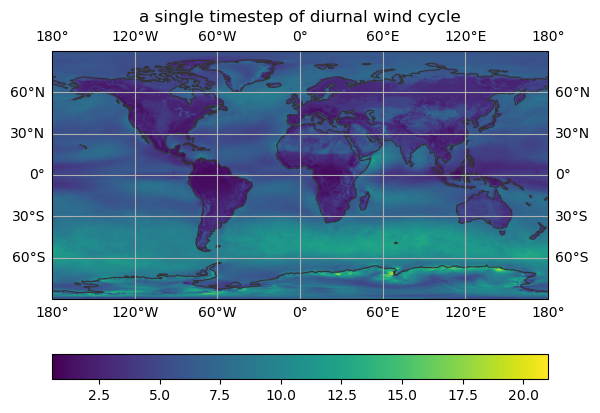

In [81]:
# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(hourly_avg_velocity1.isel(hour=6), ax=ax, add_coastlines=True)
ax.set_title(f'a single timestep of diurnal wind cycle')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [ ]:
for filename in glob.glob('/g/data/nf33/hk25_AusNode_coastal/ae7501/animation_plots/frame_*.png'):
    os.remove(filename)

for i in range(168):
    # Plotting lat/lon values over the grid
    projection=ccrs.PlateCarree(central_longitude=0.0)
    ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
    ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
    im = egh.healpix_show(velocity1.isel(time=i), ax=ax, add_coastlines=True,vmax=8,vmin=0)
    ax.set_title(f'diurnal wind cycle{i}')
    ax.gridlines(draw_labels=True)
    fig=ax.get_figure()
    fig.colorbar(im,orientation='horizontal')

         #save images to directory
    output_dir= '/g/data/nf33/hk25_AusNode_coastal/ae7501/animation_plots/'
    output_filename = os.path.join(output_dir, f'frame_{i:03d}.png')
    plt.savefig(output_filename)
    plt.close()  

# Create the movie using ffmpeg
# Output MP4 filename
output_file = 'hourly_wind_MC.mp4'
frame_rate = 4 # Frames per second

subprocess.run([
    'ffmpeg', '-framerate', str(frame_rate), '-i', '/g/data/nf33/hk25_AusNode_coastal/ae7501/animation_plots/frame_%03d.png',
    '-c:v', 'libx264', '-r', '30', '-pix_fmt', 'yuv420p', output_file
])

In [47]:
for filename in glob.glob('/g/data/nf33/ae7501/animation_plots/frame_*.png'):
    os.remove(filename)

for i in range(len(hourly_avg_velocity1.hour)):
    # Plotting lat/lon values over the grid
    projection=ccrs.PlateCarree(central_longitude=0.0)
    ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
    ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
    im = egh.healpix_show(hourly_avg_velocity1.isel(hour=i), ax=ax, add_coastlines=True,vmax=8,vmin=0)
    ax.set_title(f'diurnal wind cycle{i}')
    ax.gridlines(draw_labels=True)
    fig=ax.get_figure()
    fig.colorbar(im,orientation='horizontal')

         #save images to directory
    output_dir= '/g/data/nf33/ae7501/animation_plots/'
    output_filename = os.path.join(output_dir, f'frame_{i:03d}.png')
    plt.savefig(output_filename)
    plt.close()  

# Create the movie using ffmpeg
# Output MP4 filename
output_file = 'diurnal_wind_cycle_MC.mp4'
frame_rate = 4 # Frames per second

subprocess.run([
    'ffmpeg', '-framerate', str(frame_rate), '-i', '/g/data/nf33/ae7501/animation_plots/frame_%03d.png',
    '-c:v', 'libx264', '-r', '30', '-pix_fmt', 'yuv420p', output_file
])

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 12.3.0 (conda-forge gcc 12.3.0-7)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1716145014501/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libo

CompletedProcess(args=['ffmpeg', '-framerate', '4', '-i', '/g/data/nf33/ae7501/animation_plots/frame_%03d.png', '-c:v', 'libx264', '-r', '30', '-pix_fmt', 'yuv420p', 'diurnal_wind_cycle_MC.mp4'], returncode=0)

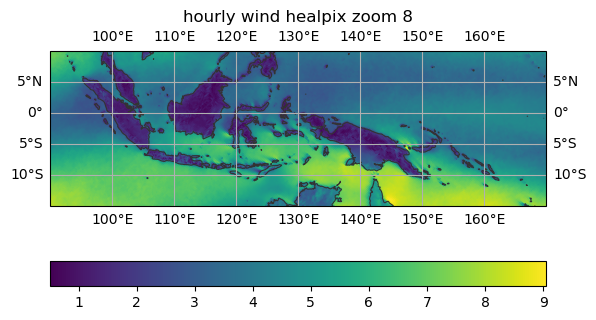

In [82]:
# Plotting the above, over Australia

# Note - we still have to use the egh wrapper functions to plot the healpix gridded data
# onto a lat/lon grid
projection = ccrs.PlateCarree(central_longitude=0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)

ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
im = egh.healpix_show(hourly_avg_velocity1.isel(hour=0), ax=ax)
#ax.coastlines()
ax.set_title(f'hourly wind healpix zoom 8')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### calculate the max min values and amplitud of the diurnal variations Healpix

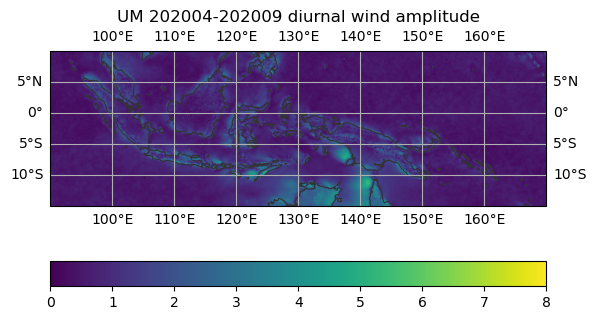

In [83]:
monthly_max=hourly_avg_velocity1.max(dim='hour') #looking at max values for each months 

#taking the maximum and minimums for whole dataset across hours and months. each cell has one value
avg_max = hourly_avg_velocity1.max(dim='hour')
avg_min = hourly_avg_velocity1.min(dim='hour')

# getting the amplitude
max_min_diff = avg_max - avg_min

#plot

projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
im = egh.healpix_show(max_min_diff, ax=ax, add_coastlines=True,vmax=8,vmin=0)
ax.set_title(f'UM 202004-202009 diurnal wind amplitude')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

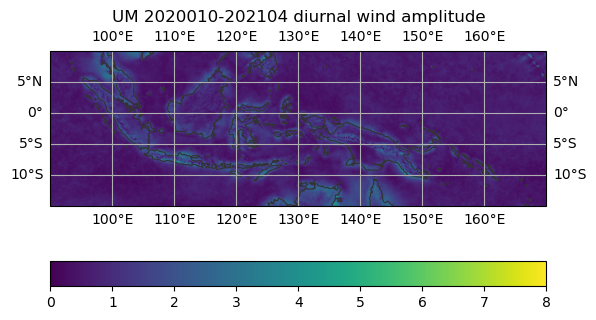

In [52]:
monthly_max=hourly_avg_velocity2.max(dim='hour') #looking at max values for each months 

#taking the maximum and minimums for whole dataset across hours. each cell has one value
avg_max = hourly_avg_velocity2.max(dim='hour')
avg_min = hourly_avg_velocity2.min(dim='hour')

# getting the amplitude
max_min_diff2 = avg_max - avg_min

#plot

projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
im = egh.healpix_show(max_min_diff2, ax=ax, add_coastlines=True,vmax=8,vmin=0)
ax.set_title(f'UM 2020010-202104 diurnal wind amplitude')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [26]:
max_min_diff2

<xarray.DataArray '__xarray_dataarray_variable__' (cell: 786432)> Size: 3MB
array([1.5599718 , 1.5564117 , 1.7060113 , ..., 1.0478797 , 1.0292549 ,
       0.96747017], dtype=float32)
Coordinates:
    crs      int64 8B 0
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    lat      (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.2984 -0.1492
    lon      (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0

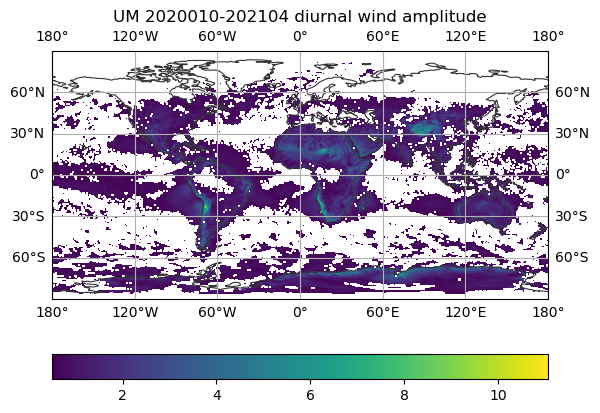

In [27]:
filtered = xr.where(max_min_diff2.values < 0.5, np.nan, max_min_diff2.values)
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(filtered, ax=ax, add_coastlines=True)
ax.set_title(f'UM 2020010-202104 diurnal wind amplitude')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### picking the timestamp for max velocity when hourly averages are done monthly

In [ ]:
#  Reshape to stack (month, hour) into a single dimension
uas_stacked = hourly_avg_velocity1.stack(time_combo=("month", "hour"))
uas_stacked

In [ ]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx = uas_stacked.argmax(dim="time_combo")
max_idx.values

In [ ]:
# this function unravvel the id of the maximum value to the hour and month.
month_indices, hour_indices = np.unravel_index(max_idx.values, (12, 24)) #

In [ ]:
# Also get the max value for each cell
max_val = uas_stacked.max(dim="time_combo")

In [ ]:
# save the max value and the timestamps into a new dataset
max_values_ds = xr.Dataset({
    "max_value": (["cell"], max_val.values),
    "month_of_max": (["cell"], month_indices),
    "hour_of_max": (["cell"], hour_indices),
})

In [ ]:
max_values_ds

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


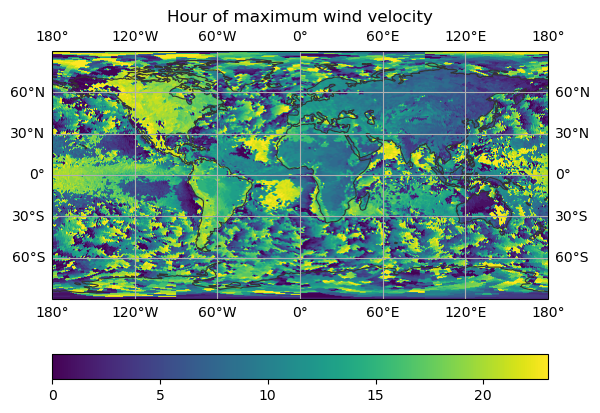

In [72]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [ ]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True,cmap=hsv)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### hour of maximum velocity

In [28]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx1 = hourly_avg_velocity1.argmax(dim="hour")
max_val1 = hourly_avg_velocity1.max(dim='hour')

In [42]:
max_val1

<xarray.DataArray '__xarray_dataarray_variable__' (cell: 786432)> Size: 3MB
array([8.080864 , 8.1272   , 8.266174 , ..., 6.351964 , 6.3786087,
       6.3757963], dtype=float32)
Coordinates:
    crs      int64 8B ...
  * cell     (cell) int64 6MB 0 1 2 3 4 5 ... 786427 786428 786429 786430 786431
    lat      (cell) float64 6MB ...
    lon      (cell) float64 6MB ...

In [29]:
# Save the max value, hour of max, and include longitude as a coordinate
max_values_ds1 = xr.Dataset({
    "max_value": max_val1,
    "hour_of_max": max_idx1,
})

max_values_ds1

<xarray.Dataset> Size: 28MB
Dimensions:      (cell: 786432)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
    lat          (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon          (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables:
    max_value    (cell) float32 3MB 8.081 8.127 8.266 ... 6.352 6.379 6.376
    hour_of_max  (cell) int64 6MB 22 22 21 21 22 21 21 22 ... 21 22 22 23 23 0 0

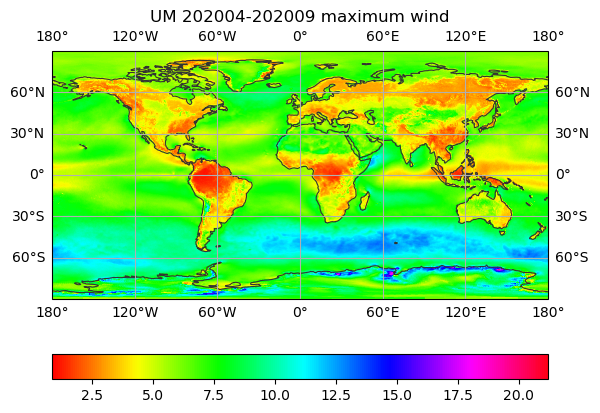

In [44]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds1.max_value, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202004-202009 maximum wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


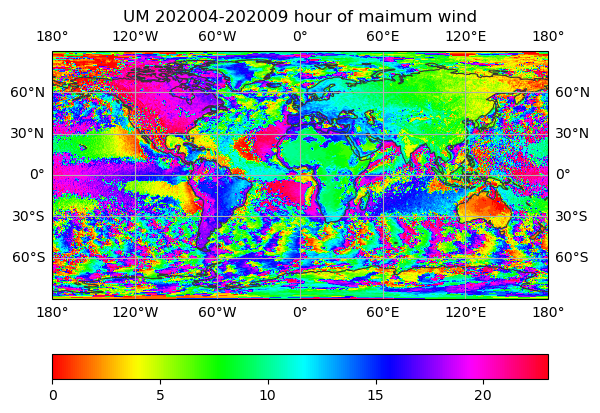

In [30]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds1.hour_of_max, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202004-202009 hour of maimum wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [31]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx2 = hourly_avg_velocity2.argmax(dim="hour")
max_val2 = hourly_avg_velocity2.max(dim='hour')

# save the max value and the timestamps into a new dataset
max_values_ds2 = xr.Dataset({
    "max_value": max_val2,
    "hour_of_max":  max_idx2,
})
max_values_ds2

<xarray.Dataset> Size: 28MB
Dimensions:      (cell: 786432)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
    lat          (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon          (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables:
    max_value    (cell) float32 3MB 8.213 8.267 8.424 ... 6.926 6.917 6.819
    hour_of_max  (cell) int64 6MB 20 20 20 20 20 19 20 19 20 ... 0 1 0 1 0 2 1 1

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


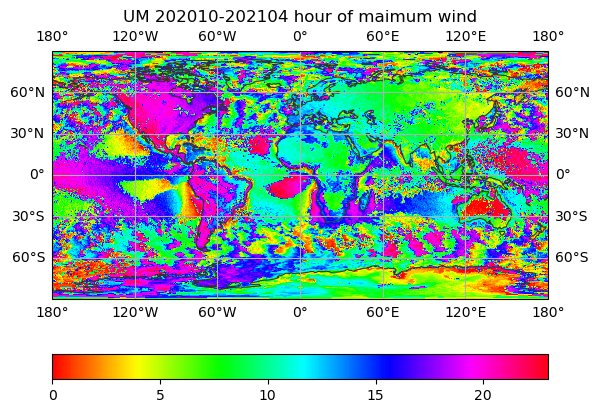

In [32]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds2.hour_of_max, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202010-202104 hour of maimum wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### convert to the local time zone

In [33]:
max_values_ds2

<xarray.Dataset> Size: 28MB
Dimensions:      (cell: 786432)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
    lat          (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon          (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables:
    max_value    (cell) float32 3MB 8.213 8.267 8.424 ... 6.926 6.917 6.819
    hour_of_max  (cell) int64 6MB 20 20 20 20 20 19 20 19 20 ... 0 1 0 1 0 2 1 1

In [29]:
def convert_to_local_time(data, longitude):
    """
    Convert time steps to local times based on longitudes.

    Parameters:
        data (xarray.DataArray): The input data with a 'time' coordinate as integers (0-23).
        longitude (xarray.DataArray or numpy array): The longitudes corresponding to the data.

    Returns:
        xarray.DataArray: The data with time converted to local times as integers.
    """
    # Calculate the time offset in hours based on longitude
    time_offset = longitude / 15.0  # 15 degrees per hour

    # Apply the time offset to convert to local time
    local_time = (data.hour_of_max + time_offset).astype(int) % 24  # Ensure times wrap around 24 hours

    # Handle negative times (e.g., -1 becomes 23)
    local_time = xr.where(local_time < 0, local_time + 24, local_time)
    local_time = xr.where(local_time>12,local_time-12,local_time)
    # Assign the local time back to the data
    data['time'] = local_time

    return data

In [59]:
time_converted_max_values_ds2 = convert_to_local_time(max_values_ds2, max_values_ds2.lon)

In [60]:
time_converted_max_values_ds2

<xarray.Dataset> Size: 35MB
Dimensions:      (cell: 786432)
Coordinates:
    crs          int64 8B 0
  * cell         (cell) int64 6MB 0 1 2 3 4 ... 786428 786429 786430 786431
    lat          (cell) float64 6MB 0.1492 0.2984 0.2984 ... -0.2984 -0.1492
    lon          (cell) float64 6MB 45.0 45.18 44.82 45.0 ... 315.2 314.8 315.0
Data variables:
    max_value    (cell) float32 3MB 8.213 8.267 8.424 ... 6.926 6.917 6.819
    hour_of_max  (cell) int64 6MB 20 20 20 20 20 19 20 19 20 ... 0 1 0 1 0 2 1 1
    time         (cell) int64 6MB 11 11 10 11 11 10 11 10 ... 8 9 8 9 9 11 9 10

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


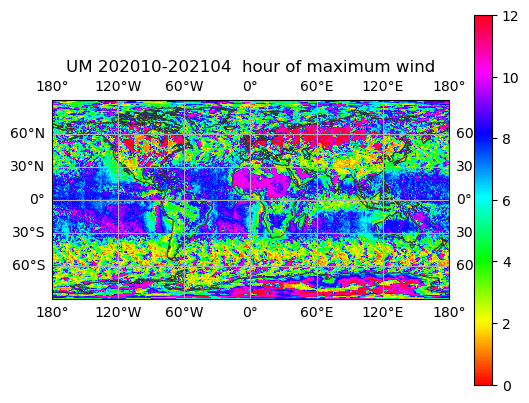

In [61]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(time_converted_max_values_ds2.time, ax=ax, add_coastlines=True,cmap=cm.hsv)
ax.set_title(f'UM 202010-202104  hour of maximum wind')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='vertical')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


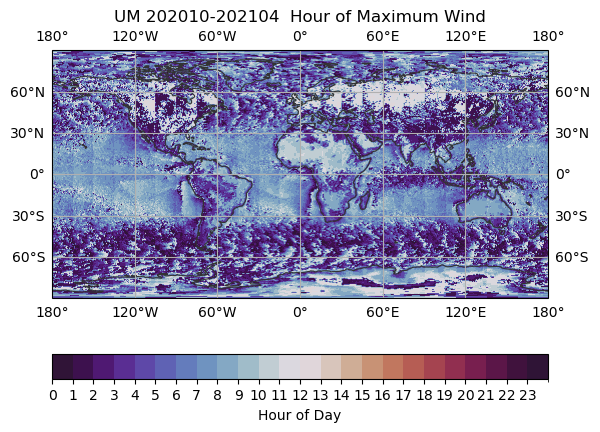

In [62]:


# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.twilight_shifted(np.linspace(0, 1, 24)))
bounds = np.arange(25)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up projection and plot
projection = ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
im = egh.healpix_show(time_converted_max_values_ds2.time, ax=ax, cmap=cmap, norm=norm, add_coastlines=True)

# Plot styling
ax.set_title('UM 202010-202104  Hour of Maximum Wind')
ax.gridlines(draw_labels=True)

# Add colorbar with 24 ticks (0 to 23)
fig = ax.get_figure()
cbar = fig.colorbar(im, orientation='horizontal', ticks=np.arange(24))
cbar.set_label("Hour of Day")

plt.show()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


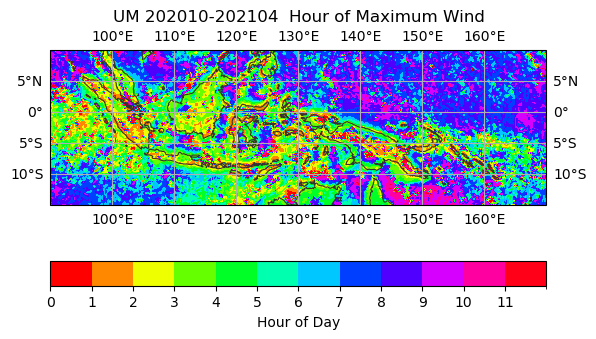

In [68]:

# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.hsv(np.linspace(0, 1, 12)))
bounds = np.arange(13)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up projection and plot
projection = ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
im = egh.healpix_show(time_converted_max_values_ds2.time, ax=ax, cmap=cmap, norm=norm, add_coastlines=True)

# Plot styling
ax.set_title('UM 202010-202104  Hour of Maximum Wind')
ax.gridlines(draw_labels=True)

# Add colorbar with 24 ticks (0 to 23)
fig = ax.get_figure()
cbar = fig.colorbar(im, orientation='horizontal', ticks=np.arange(12))
cbar.set_label("Hour of Day from moon or midnight")

plt.show()

In [64]:
time_converted_max_values_ds1 = convert_to_local_time(max_values_ds1, max_values_ds1.lon)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


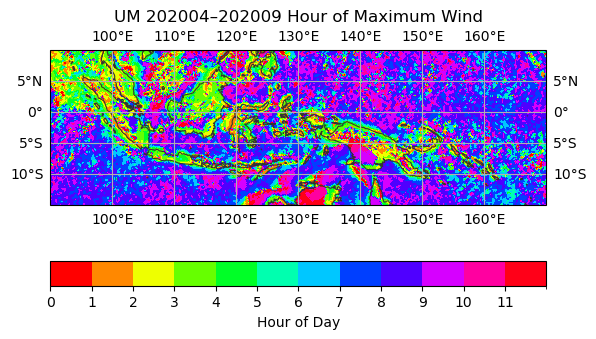

In [69]:
# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.hsv(np.linspace(0, 1, 12)))
bounds = np.arange(13)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up projection and plot
projection = ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True, projection=projection)
ax.set_extent([90, 170,-15, 10], crs=ccrs.PlateCarree())
im = egh.healpix_show(time_converted_max_values_ds1.time, ax=ax, cmap=cmap, norm=norm, add_coastlines=True)

# Plot styling
ax.set_title('UM 202004–202009 Hour of Maximum Wind')
ax.gridlines(draw_labels=True)

# Add colorbar with 24 ticks (0 to 23)
fig = ax.get_figure()
cbar = fig.colorbar(im, orientation='horizontal', ticks=np.arange(12))
cbar.set_label("Hour of Day from noon or midnight")

plt.show()

### ERA plots

In [17]:
hourly_avg_era51 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501//era_hourly_avg1.nc').__xarray_dataarray_variable__
hourly_avg_era52 = xr.open_dataset('/g/data/nf33/hk25_AusNode_coastal/ae7501//era_hourly_avg2.nc').__xarray_dataarray_variable__

In [24]:
hourly_avg_era51

<xarray.DataArray '__xarray_dataarray_variable__' (hour: 24, latitude: 721,
                                                   longitude: 1440)> Size: 199MB
[24917760 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * hour       (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23

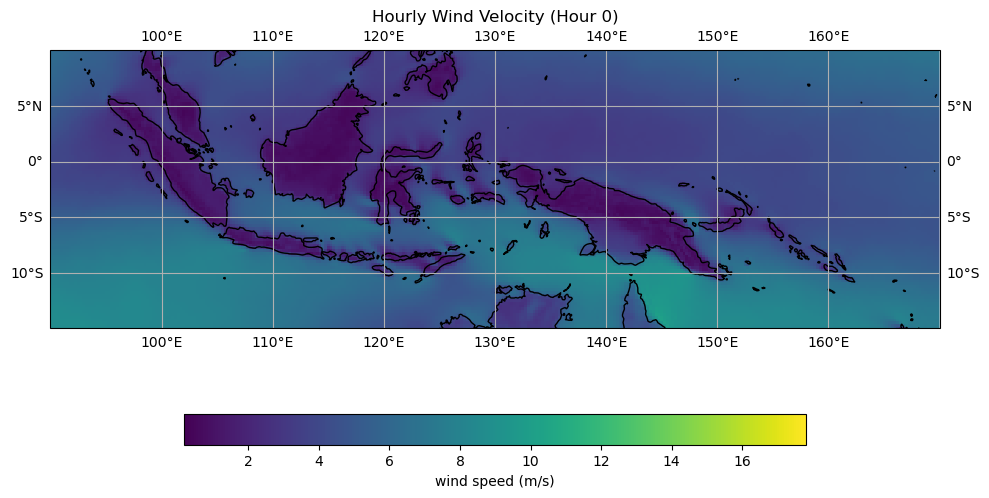

In [32]:
# Select one time or hour slice if needed
data_to_plot = hourly_avg_era51.isel(hour=0)  # or .isel(time=0) depending on dimensions

# Set up map projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
)

# Define map extent (Australia region)
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

# Plot the data
p = ax.pcolormesh(
    data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
    transform=ccrs.PlateCarree(),
    shading='auto', cmap='viridis'
)

# Add coastlines and grid
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add title and colorbar
ax.set_title("Hourly Wind Velocity (Hour 0)")
fig.colorbar(p, ax=ax, orientation='horizontal', label= "wind speed (m/s)",shrink=0.7)

plt.tight_layout()
plt.show()


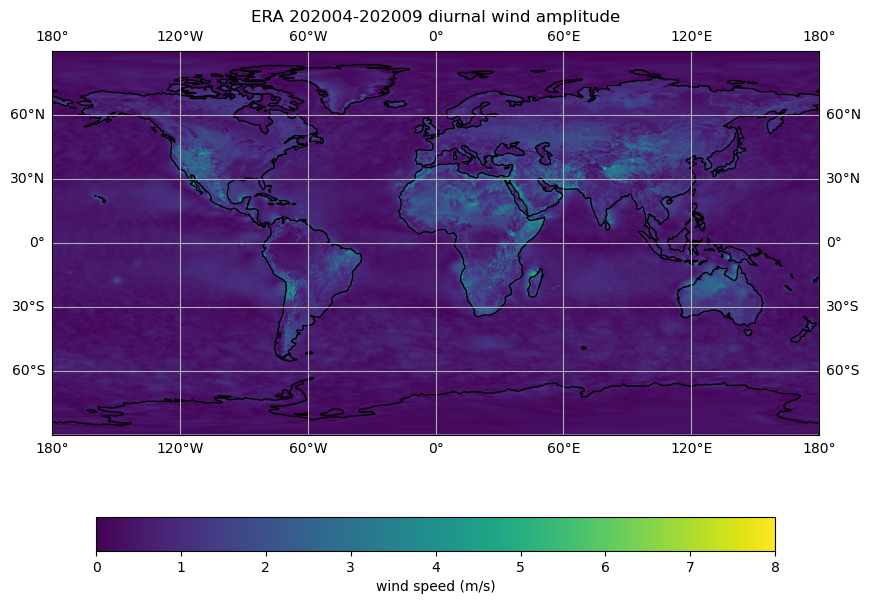

In [23]:
#taking the maximum and minimums for whole dataset across hours and months. each cell has one value
avg_max = hourly_avg_era51.max(dim='hour')
avg_min = hourly_avg_era51.min(dim='hour')

# getting the amplitude
max_min_diff = avg_max - avg_min


""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""


#plot

# Select one time or hour slice if needed
data_to_plot = max_min_diff  # or .isel(time=0) depending on dimensions

# Set up map projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
)

# Define map extent (Australia region)
#ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

# Plot the data
p = ax.pcolormesh(
    data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
    transform=ccrs.PlateCarree(),
    shading='auto', cmap='viridis',vmin=0,vmax=8
)

# Add coastlines and grid
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add title and colorbar
ax.set_title("ERA 202004-202009 diurnal wind amplitude")
fig.colorbar(p, ax=ax, orientation='horizontal', label= "wind speed (m/s)",shrink=0.7)

plt.tight_layout()
plt.show()


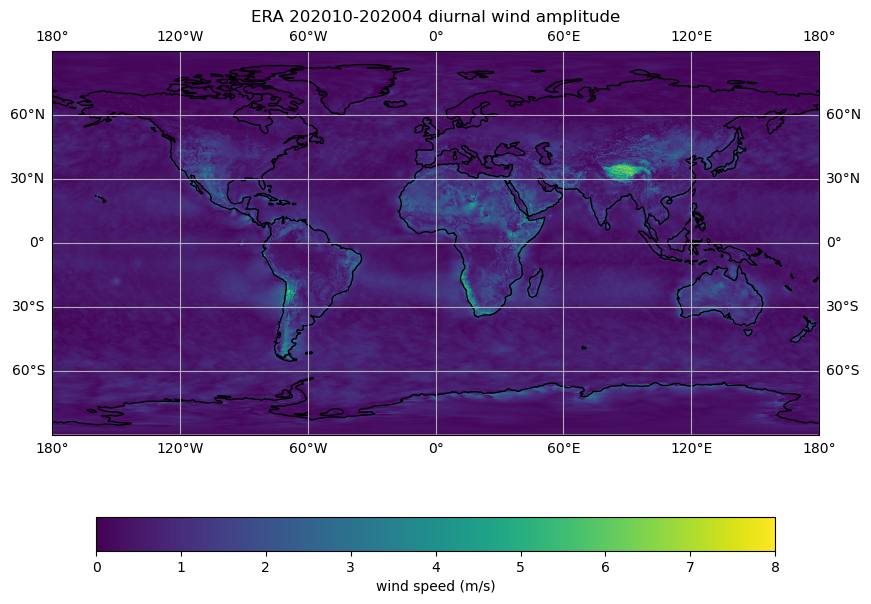

In [24]:
#taking the maximum and minimums for whole dataset across hours and months. each cell has one value
avg_max = hourly_avg_era52.max(dim='hour')
avg_min = hourly_avg_era52.min(dim='hour')

# getting the amplitude
max_min_diff = avg_max - avg_min

""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""

#plot

# Select one time or hour slice if needed
data_to_plot = max_min_diff  # or .isel(time=0) depending on dimensions

# Set up map projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
)

# Define map extent (Australia region)
#ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

# Plot the data
p = ax.pcolormesh(
    data_to_plot.longitude, data_to_plot.latitude, data_to_plot,
    transform=ccrs.PlateCarree(),
    shading='auto', cmap='viridis',vmin=0,vmax=8
)

# Add coastlines and grid
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add title and colorbar
ax.set_title("ERA 202010-202004 diurnal wind amplitude")
fig.colorbar(p, ax=ax, orientation='horizontal', label= "wind speed (m/s)",shrink=0.7)

plt.tight_layout()
plt.show()


### ERA 5 timing plots

In [67]:
def convert_to_local_time2(data, longitude):
    """
    Convert time steps to local times based on longitudes.

    Parameters:
        data (xarray.DataArray): The input data with a 'time' coordinate as integers (0-23).
        longitude (xarray.DataArray or numpy array): The longitudes corresponding to the data.

    Returns:
        xarray.DataArray: The data with time converted to local times as integers.
    """
    # Calculate the time offset in hours based on longitude
    time_offset = longitude / 15.0  # 15 degrees per hour

    # Apply the time offset to convert to local time
    local_time = (data.hour_of_max + time_offset).astype(int) % 24  # Ensure times wrap around 24 hours

    # Handle negative times (e.g., -1 becomes 23)
    local_time = xr.where(local_time < 0, local_time + 24, local_time)
    local_time = xr.where(local_time>12,local_time-12,local_time)
    # Assign the local time back to the data
    data['time'] = local_time

    return data

In [54]:
# Find the index of the max along hour dim
max_idx1 = hourly_avg_era51.argmax(dim="hour")
max_val1 = hourly_avg_era51.max(dim='hour')

# Save the max value, hour of max, and include longitude as a coordinate
max_values_ds1 = xr.Dataset({
    "max_value": max_val1,
    "hour_of_max": max_idx1,
})

In [55]:
# Find the index of the max along hour dim
max_idx2 = hourly_avg_velocity2.argmax(dim="hour")
max_val2 = hourly_avg_velocity2.max(dim='hour')

# save the max value and the timestamps into a new dataset
max_values_ds2 = xr.Dataset({
    "max_value": max_val2,
    "hour_of_max":  max_idx2,
})
max_values_ds2

<xarray.Dataset> Size: 17MB
Dimensions:      (longitude: 1440, latitude: 721)
Coordinates:
  * longitude    (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude     (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    max_value    (latitude, longitude) float64 8MB 0.4796 0.4796 ... 0.509 0.509
    hour_of_max  (latitude, longitude) int64 8MB 13 13 13 13 13 13 ... 0 0 0 0 0

In [75]:
time_converted_max_values_ds1 = convert_to_local_time2(max_values_ds1, max_values_ds1.longitude)

In [76]:
time_converted_max_values_ds1

<xarray.Dataset> Size: 25MB
Dimensions:      (longitude: 1440, latitude: 721)
Coordinates:
  * longitude    (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude     (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Data variables:
    max_value    (latitude, longitude) float64 8MB 0.4159 0.4159 ... 0.6673
    hour_of_max  (latitude, longitude) int64 8MB 10 10 10 10 10 ... 21 21 21 21
    time         (latitude, longitude) int64 8MB 10 11 11 11 11 11 ... 8 8 8 8 8

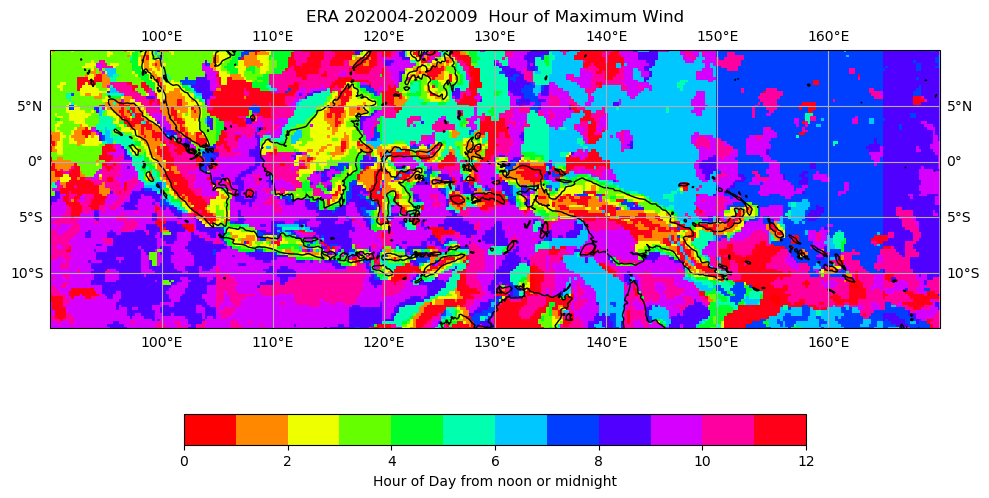

In [77]:
# Select one time or hour slice if needed
data_to_plot = time_converted_max_values_ds1  
# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.hsv(np.linspace(0, 1, 12)))
bounds = np.arange(13)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up map projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
)

# Define map extent (Australia region)
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

# Plot the data
p = ax.pcolormesh(
    data_to_plot.longitude, data_to_plot.latitude, data_to_plot.time,
    transform=ccrs.PlateCarree(),
    shading='auto', cmap=cmap
)

# Add coastlines and grid
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add title and colorbar
ax.set_title("ERA 202004-202009  Hour of Maximum Wind")
fig.colorbar(p, ax=ax, orientation='horizontal', label= "Hour of Day from noon or midnight",shrink=0.7)

plt.tight_layout()
plt.show()

In [78]:
time_converted_max_values_ds2 = convert_to_local_time2(max_values_ds2, max_values_ds2.longitude)

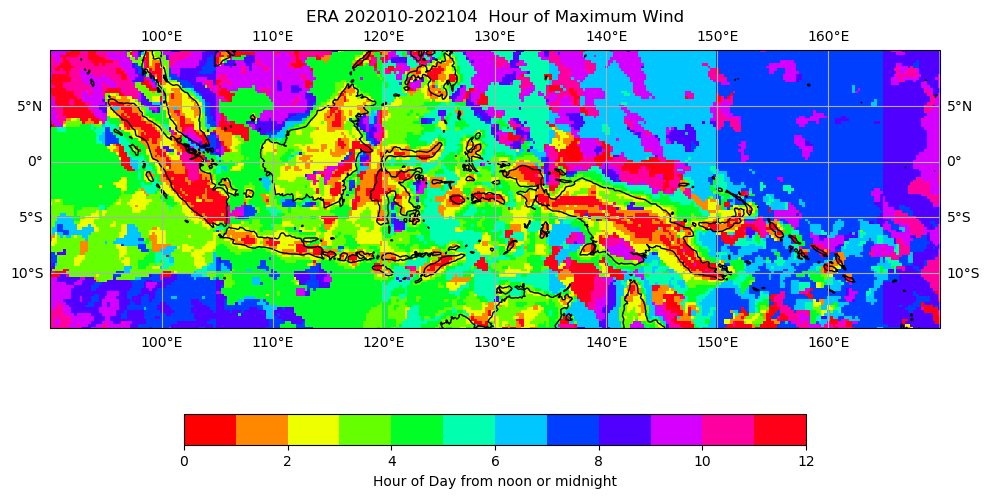

In [79]:
# Select one time or hour slice if needed
data_to_plot = time_converted_max_values_ds2  # or .isel(time=0) depending on dimensions
# Create discrete colormap with 24 colors from HSV
cmap = ListedColormap(cm.hsv(np.linspace(0, 1, 12)))
bounds = np.arange(13)  # 0 to 24, to create 24 bins
norm = BoundaryNorm(bounds, cmap.N)

# Set up map projection
fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)}
)

# Define map extent (Australia region)
ax.set_extent([90, 170, -15, 10], crs=ccrs.PlateCarree())

# Plot the data
p = ax.pcolormesh(
    data_to_plot.longitude, data_to_plot.latitude, data_to_plot.time,
    transform=ccrs.PlateCarree(),
    shading='auto', cmap=cmap
)

# Add coastlines and grid
ax.coastlines()
ax.gridlines(draw_labels=True)

# Add title and colorbar
ax.set_title("ERA 202010-202104  Hour of Maximum Wind")
fig.colorbar(p, ax=ax, orientation='horizontal', label= "Hour of Day from noon or midnight",shrink=0.7)

plt.tight_layout()
plt.show()